In [1]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.stats as stats
from scipy.fft import fft, fftfreq
import scipy.signal as sig
from sklearn import linear_model

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import util
import plotutils as pu

%matplotlib inline

## Set matplotlib

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    

def get_results(testcase, config, runs):
    modelname = "AN"
    path = f"../run/main/{testcase}/model{modelname}/{config}"
    ds = ndsv.Dataset.from_file(f"../run/main/{testcase}/dataset.npz")
    run = util.select_run(testcase, modelname, config, [0,1])
    surr   = ndsv.GeneratedData.from_file(f"../run/main/{testcase}/surrogates.npz")
    sims   = ndsv.GeneratedData.from_file(f"{path}/run{run:02d}/simulations.npz")
    params = ndsv.Params.from_file(f"{path}/run{run:02d}/parameters.npz")
        
    return dotdict(ds=ds, sims=sims, params=params, surr=surr)

res = get_results("hopf", "ns_2_mreg_2_msub_1_nf_32", [0,1])

In [4]:
def smooth(y, box_pts, axis=-1):
    # Move desired axis to 0-th axis
    y = np.moveaxis(y, [axis] + list(np.r_[:axis]), [0] + list(np.r_[1:axis+1]))
    shape = y.shape
    
    # Flatten all other axes
    y = np.reshape(y, (y.shape[0], -1))
    ysmooth = np.zeros_like(y)
    
    # Convolve
    box = np.ones(box_pts)/box_pts
    for i in range(y.shape[1]):
        ysmooth[:,i] = np.convolve(y[:,i], box, mode='same')
        
    # Reshape and move again
    ysmooth = np.reshape(ysmooth, shape)
    ysmooth = np.moveaxis(ysmooth, [0] + list(np.r_[1:axis+1]), [axis] + list(np.r_[:axis]))
    
    return ysmooth


def get_smooth_spectrum_fun(fs, nsmooth):
    def smooth_spectrum(y, axis):
        f, pxx = sig.periodogram(y, fs=fs, axis=axis)
        pxx = smooth(pxx, nsmooth)
        return pxx
    return smooth_spectrum

    
def cosine_similarity(a, b):
    return np.sum(a * b, axis=-1)/(np.sqrt(np.sum(a * a, axis=-1) * np.sum(b * b, axis=-1)))
    
    
def identity(x, axis):
    return x

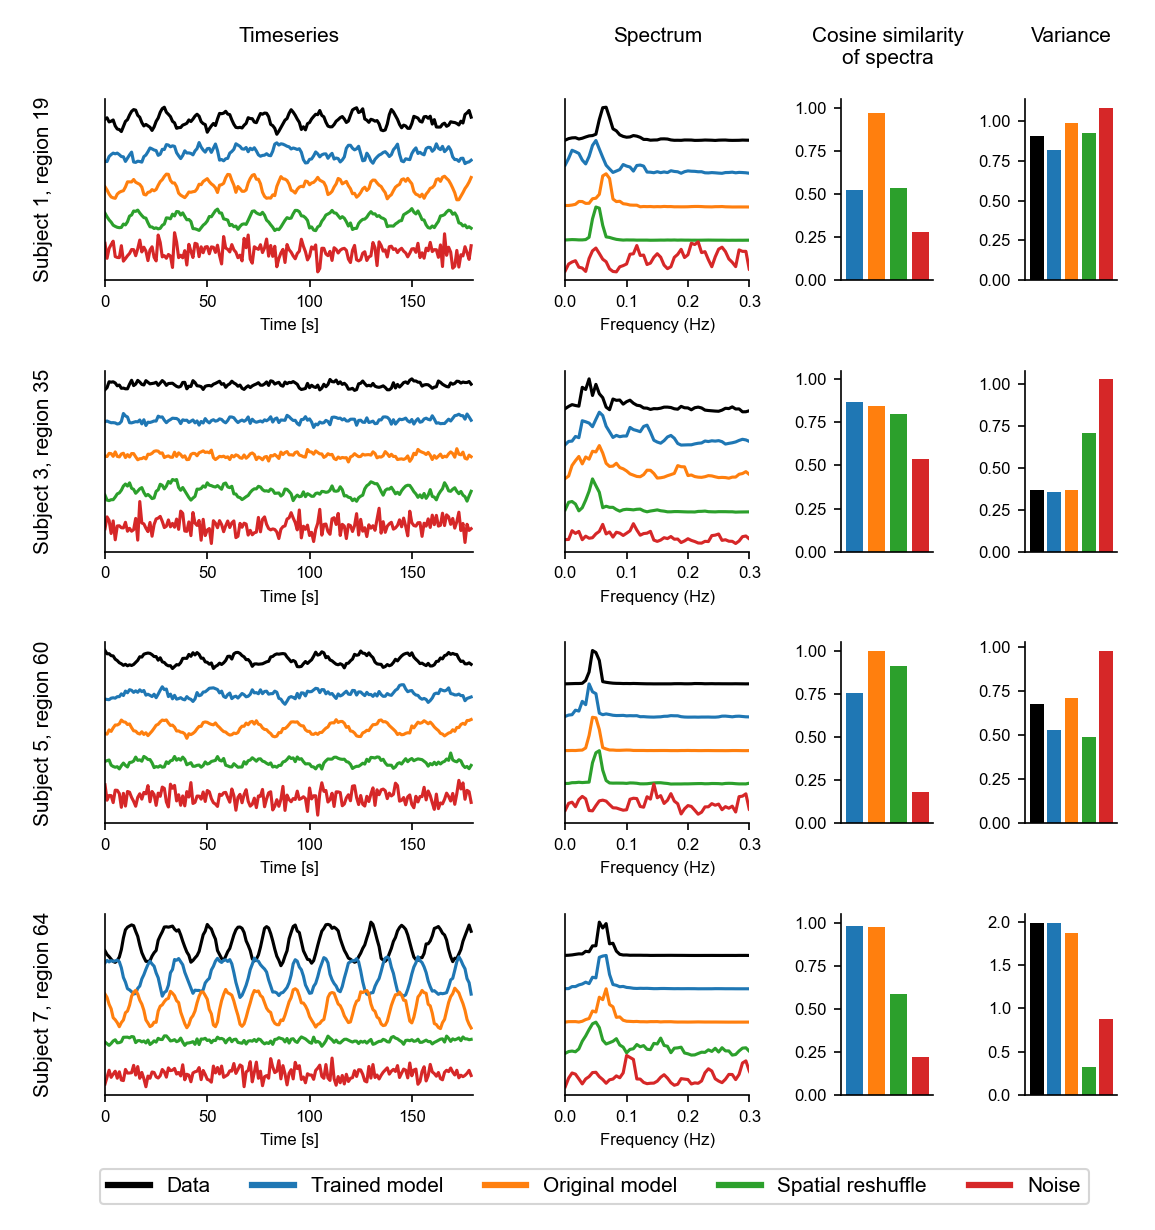

In [16]:
examples = [(1, 19, 45), (3, 35, 45), (5, 60, 45), (7, 64, 45)]
n = len(examples)
nt = res.ds.y.shape[-1]
nsub = 8
nreg = 68

# np.random.seed(43)
np.random.seed(47)

colors = ['k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ["Data", "Trained model", "Original model", "Spatial reshuffle", "Noise"]

fig = plt.figure(figsize=(7.5, n*2), dpi=150)

gs = GridSpec(nrows=n, ncols=4, left=0.08, right=0.98, top=0.93, bottom=0.1,  hspace=0.5, wspace=0.5,
              width_ratios=(2,1,0.5,0.5))


fs = 1./(res.ds.t[1] - res.ds.t[0])
f = sig.periodogram(res.ds.y[0,0,0,:] , fs=fs, axis=0)[0]

for i, (isub, ireg, irand) in enumerate(examples):
    
    # Get data
    y0 = res.ds.y[isub,ireg,0,:] 
    y1 = res.sims.y[irand,isub,ireg,0,-nt:]
    y2 = res.surr.y[3,isub,ireg,0,:]
    y3 = res.ds.y[np.random.choice(nsub),np.random.choice(nreg),0,:]
    y4 = np.random.normal(0, 1, nt)    
    ys = [y0,y1,y2,y3,y4]
    
    
    # Time series
    ax = plt.subplot(gs[i,0])
    
    for j, y in enumerate(ys):
        plt.plot(y - 5*j, color=colors[j], label=labels[j])
    plt.xlim(0, nt)
    plt.xlabel("Time [s]")
    pu.bottomleft_spines(ax)
    plt.yticks([])    
    plt.ylabel(f"Subject {isub}, region {ireg}\n\n", fontsize=10)
    if i == 0:
        plt.title("Timeseries\n\n", fontsize=10)
    
    if i == n-1:
        leg = plt.legend(bbox_to_anchor=(2.7, -0.35), ncol=5, fontsize=10)
        for line in leg.get_lines():
            line.set_linewidth(3)
    
    # Spectra
    smooth_spectrum = get_smooth_spectrum_fun(fs, 3)
    sss = [smooth_spectrum(y, axis=0) for y in ys]
    
    ax = plt.subplot(gs[i,1])
    for j, ss in enumerate(sss):
        plt.plot(f, ss/np.max(ss) - 1*j, color=colors[j])
    plt.xlim(0, 0.3)
    if i == 0:
        plt.title("Spectrum\n\n", fontsize=10)
    plt.yticks([])
    plt.xlabel("Frequency (Hz)")
    pu.bottomleft_spines(ax)    
    
    # Cosine similarity
    ax = plt.subplot(gs[i,2])
    
    plt.bar(np.r_[:4], [cosine_similarity(sss[0], ss) for ss in sss[1:]], color=colors[1:])
    plt.ylim(0, 1.05)
    if i == 0:
        plt.title("Cosine similarity\nof spectra\n", fontsize=10)
    pu.bottomleft_spines(ax)
    plt.xticks([])
    
    
    # Variance
    ax = plt.subplot(gs[i,3])
    plt.bar(np.r_[:5], [np.std(y) for y in ys], color=colors)    
    if i == 0:
        plt.title("Variance\n\n", fontsize=10)
    pu.bottomleft_spines(ax)
    plt.xticks([])



bg = pu.Background(visible=False)
plt.savefig("img/Fig_hopf_examples.pdf")